<a href="https://colab.research.google.com/github/raminass/scotus/blob/main/train_model_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [ ]:
!pip install datasets evaluate transformers accelerate eyecite --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/projects/us_supreme_court

/content/drive/MyDrive/projects/us_supreme_court


In [4]:
from utils.pre_train import *
from utils.notebook_utils import *

%load_ext autoreload
%autoreload 2

# Read Data

## 2020-2023

In [5]:
opinions_20_23 = pd.read_excel('data/2020-2023.xlsx')
opinions_20_23 = opinions_20_23[['Text', 'Opinion', 'Judge', 'Case']]
opinions_20_23.fillna(method='ffill', inplace=True)
opinions_20_23 = opinions_20_23.groupby(['Opinion', 'Judge', 'Case'])['Text'].apply(lambda x: ' '.join(x)).reset_index()
opinions_20_23.rename(columns={'Text': 'text', 'Opinion':'type', 'Judge':'author', 'Case':'case_name'}, inplace=True)

In [6]:
opinions_20_23['author'] = opinions_20_23['author'].replace(['Kavanaugh ',"Barret","S", "PER CURIAM"],[ 'Kavanaugh', "Barrett", "Sotomayor","per_curiam"])
opinions_20_23['type'] = opinions_20_23['type'].replace(['Majority',"Concur","Dissent", "PER CURIAM"],[ 'majority', "concurring", "dissenting","per_curiam"])
opinions_20_23['author'] = opinions_20_23['author'].replace(['Gorsuch '], ['Gorsuch'])
opinions_20_23 = opinions_20_23[opinions_20_23.author!='Ginsburg']

In [ ]:
opinions_20_23.author.unique()

array(['Alito', 'Barrett', 'Breyer', 'Gorsuch', 'Jackson', 'Kagan',
       'Kavanaugh', 'Roberts', 'Sotomayor', 'Thomas', 'per_curiam'],
      dtype=object)

In [ ]:
opinions_20_23.shape

(438, 4)

In [ ]:
opinions_20_23.sample(5)

,type,author,case_name,text
231,dissenting,Thomas,"Hemphill v. New York, 20-637",This Court may review “[f]inal judgments or de...
195,dissenting,Kagan,"Brnovich v. Democratic National Committee, 19...",If a single statute represents the best of Am...
343,majority,Kavanaugh,"American Hospital Assn. v. Becerra, 20-1114","Under the Medicare statute, the Department of..."
21,concurring,Barrett,"United States v. Tsarnaev, 20-443","In this case, the First Circuit asserted “sup..."
403,majority,Thomas,"Brownback v. King, 19-546",The Federal Tort Claims Act (FTCA) allows a pl...


In [ ]:
opinions_20_23.author.value_counts()

Thomas        72
Gorsuch       62
Sotomayor     51
Alito         47
Kavanaugh     45
Barrett       36
Kagan         35
Roberts       29
Breyer        27
Jackson       18
per_curiam    16
Name: author, dtype: int64

In [ ]:
opinions_20_23.type.value_counts()

majority      174
concurring    137
dissenting    111
per_curiam     16
Name: type, dtype: int64

In [10]:
opinions_20_23[~opinions_20_23.author.isin(['Jackson', 'Barrett', 'Kavanaugh'])].type.value_counts()

majority      132
concurring    100
dissenting     91
per_curiam     16
Name: type, dtype: int64

## 1994-2020

In [ ]:
# filter dates and Judges
opinions_since_1970 = pd.read_csv('data/opinions_since_1970.csv')
opinions_1994_2020 = opinions_since_1970[(opinions_since_1970['date_filed'] > "1994-09-01")].copy()
opinions_1994_2020['author_name'] = opinions_1994_2020['author_name'].replace(['Justice O2122','Justice Connor'],["Justice O'Connor", "Justice O'Connor"])

# j_list = ['Justice Roberts', 'Justice Thomas', 'Justice Breyer',
#        'Justice Kagan', 'Justice Scalia', 'Justice Kennedy', 'per_curiam',
#        'Justice Ginsburg', 'Justice Alito',
#        'Justice Stevens', 'Justice Rehnquist',
#        'Justice Souter', "Justice O'Connor", 'Justice Sotomayor']

old_j = ["Justice White", "Justice Holmes", "Justice Woods", "Justice Waite", "Justice Fuller", "Justice McReynolds"]
opinions_1994_2020 = opinions_1994_2020[~opinions_1994_2020['author_name'].isin(old_j)]
opinions_1994_2020 = opinions_1994_2020[['author_name', 'category', 'case_name', 'text']]
opinions_1994_2020.rename(columns={'category':'type', 'author_name':'author'}, inplace=True)
opinions_1994_2020['author'] = opinions_1994_2020['author'].replace(['Justice Thomas','Justice Scalia', 'Justice Breyer', 'Justice Stevens','Justice Ginsburg', 'Justice Kennedy', 'Justice Alito', 'Justice Souter', 'Justice Sotomayor', "Justice O'Connor", "Justice Rehnquist", "Justice Kagan", "Justice Roberts", "Justice Kavanaugh", "Justice Gorsuch"],
                                                          ["Thomas", "Scalia", "Breyer", "Stevens", "Ginsburg", "Kennedy", "Alito", "Souter", "Sotomayor", "O'Connor", "Rehnquist", "Kagan", "Roberts", "Kavanaugh", "Gorsuch"])


In [ ]:
opinions_1994_2020.author.value_counts()

Thomas        499
Scalia        473
Breyer        416
Stevens       407
Ginsburg      390
Kennedy       326
Alito         239
Souter        230
Sotomayor     175
O'Connor      167
Rehnquist     144
per_curiam    120
Kagan         110
Roberts        94
Gorsuch        47
Kavanaugh      20
Name: author, dtype: int64

In [ ]:
opinions_1994_2020.type.value_counts()

majority             1810
dissenting            967
concurring            711
second_dissenting     249
per_curiam            120
Name: type, dtype: int64

In [ ]:
opinions = pd.concat([opinions_20_23, opinions_1994_2020], ignore_index=True)

In [ ]:
opinions.shape

(4295, 4)

In [ ]:
opinions.author.value_counts()

Thomas        571
Scalia        473
Breyer        443
Stevens       407
Ginsburg      390
Kennedy       326
Alito         286
Souter        230
Sotomayor     226
O'Connor      167
Kagan         145
Rehnquist     144
per_curiam    136
Roberts       123
Gorsuch       109
Kavanaugh      65
Barrett        36
Jackson        18
Name: author, dtype: int64

In [ ]:
opinions.author.unique()

array(['Alito', 'Barrett', 'Breyer', 'Gorsuch', 'Jackson', 'Kagan',
       'Kavanaugh', 'Roberts', 'Sotomayor', 'Thomas', 'per_curiam',
       'Kennedy', 'Ginsburg', 'Scalia', 'Stevens', 'Rehnquist', 'Souter',
       "O'Connor"], dtype=object)

In [ ]:
opinions.shape

(4295, 4)

# Cleaning the Citations

In [ ]:
opinions['type'] = opinions['type'].replace(['second_dissenting'],['dissenting'])

In [ ]:
opinions.type.value_counts()

majority      1984
dissenting    1327
concurring     848
per_curiam     136
Name: type, dtype: int64

In [ ]:
opinions['clean_text'] = opinions.apply(lambda x: remove_citations(x['text']), axis=1)

In [ ]:
opinions["clean_text"] = opinions.apply(
    lambda x: x.clean_text.split("It is so ordered.")[0]
    if x.type == "majority"
    else x.clean_text,
    axis=1,
)

In [ ]:
import os
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
opinions_ds = Dataset.from_pandas(opinions, preserve_index=False)
opinions_ds.push_to_hub("raminass/opinions-94-23")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/425 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/raminass/opinions-94-23/commit/9c50d8c4a4920c69823d93cf7508aedbc911eb4d', commit_message='Upload dataset', commit_description='', oid='9c50d8c4a4920c69823d93cf7508aedbc911eb4d', pr_url=None, pr_revision=None, pr_num=None)

# Train-Test

In [ ]:
all = load_dataset("raminass/opinions-94-23")
opinions = pd.DataFrame(all["train"])

In [ ]:
opinions=opinions[opinions.author!='per_curiam']

In [ ]:
opinions.type.value_counts()

majority      1984
dissenting    1327
concurring     848
Name: type, dtype: int64

In [ ]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
O'Connor     167
Kagan        145
Rehnquist    144
Roberts      123
Gorsuch      109
Kavanaugh     65
Barrett       36
Jackson       18
Name: author, dtype: int64

In [ ]:
id2label, label2id = get_labels_maping(opinions)
opinions["label"] = opinions["author"].map(label2id)

In [ ]:
from sklearn.model_selection import train_test_split

opinions_train, opinions_test = train_test_split(opinions, random_state=1984, test_size=0.2, stratify=opinions['label'])

In [ ]:
opinions_test.author.value_counts()

Thomas       114
Scalia        95
Breyer        89
Stevens       81
Ginsburg      78
Kennedy       65
Alito         57
Souter        46
Sotomayor     45
O'Connor      33
Kagan         29
Rehnquist     29
Roberts       25
Gorsuch       22
Kavanaugh     13
Barrett        7
Jackson        4
Name: author, dtype: int64

In [ ]:
opinions_train.author.value_counts()

Thomas       457
Scalia       378
Breyer       354
Stevens      326
Ginsburg     312
Kennedy      261
Alito        229
Souter       184
Sotomayor    181
O'Connor     134
Kagan        116
Rehnquist    115
Roberts       98
Gorsuch       87
Kavanaugh     52
Barrett       29
Jackson       14
Name: author, dtype: int64

# Split Paragraphs

In [ ]:
par_train = split_data(opinions_train, id2label, label2id)
par_test = split_data(opinions_test, id2label, label2id)

In [ ]:
par_train.author.value_counts()

Thomas       3677
Breyer       3069
Scalia       2807
Kennedy      2724
Alito        2594
Ginsburg     2533
Stevens      2126
Sotomayor    1881
Souter       1590
Kagan        1372
O'Connor     1170
Roberts      1015
Gorsuch       927
Rehnquist     768
Kavanaugh     349
Barrett       239
Jackson       114
Name: author, dtype: int64

In [ ]:
par_test.author.value_counts()

Breyer       864
Scalia       860
Thomas       822
Kennedy      721
Alito        699
Ginsburg     645
Stevens      449
Sotomayor    438
Kagan        380
Souter       361
Roberts      305
O'Connor     294
Gorsuch      267
Rehnquist    161
Kavanaugh    107
Jackson       51
Barrett       38
Name: author, dtype: int64

In [ ]:
par_train = par_train.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(3000, replace=len(s)<3000))

In [ ]:
par_train.author.value_counts()

In [ ]:
# par_test = par_test.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(400, replace=len(s)<400))

In [ ]:
par_test.author.value_counts()

# Model

In [ ]:
from utils import train

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds_dict = {
        "train": Dataset.from_pandas(
            par_train[["label", "text"]], preserve_index=False
        ),
        "test": Dataset.from_pandas(
            par_test[["label", "text"]], preserve_index=False
        ),
    }
ds = DatasetDict(ds_dict)
tokenized_court = train.tokenize_dataset(ds)

Map:   0%|          | 0/51000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7462 [00:00<?, ? examples/s]

In [ ]:
 trainer = train.get_trainer(
        id2label,
        label2id,
        tokenized_court,
        epochs=5,
        model_name=f"SCOTUS_AI_17",
        batch_size=16,
        push_to_hub=True,
    )
trainer.train()

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/raminass/SCOTUS_AI_17/commit/4465ecae5abebfccadab219425a0a37e73f93dc8', commit_message='End of training', commit_description='', oid='4465ecae5abebfccadab219425a0a37e73f93dc8', pr_url=None, pr_revision=None, pr_num=None)

# Analysis

In [ ]:
from scipy.special import softmax
pred = []
for index, row in opinions_test.iterrows():
  chunks = split_text(row["clean_text"])
  list_ds = [{"text":c} for c in chunks]
  tokenized_case = train.tokenize_dataset(Dataset.from_list(list_ds))
  predictions = trainer.predict(tokenized_case)
  avg = softmax(predictions.predictions, axis=1).mean(axis=0)
  pred.append(np.argmax(avg))

In [ ]:
(pred == opinions_test['label']).mean()

0.90625

In [ ]:
from utils import metrics

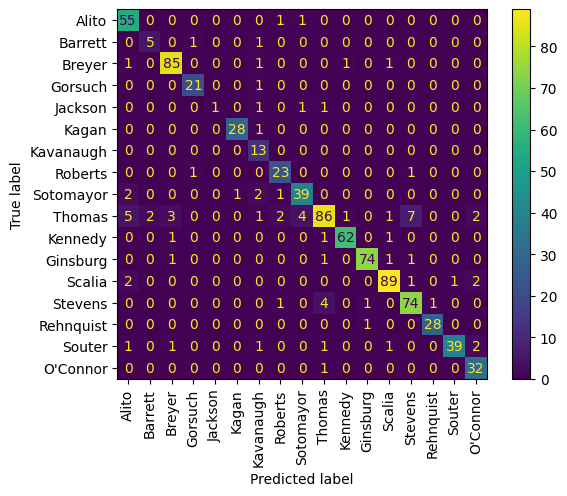

In [ ]:
metrics.plot_confusion(opinions_test['label'],pred, label2id)

In [ ]:
metrics.print_metrics(opinions_test['author'],[id2label[i] for i in pred])


-------------------- Key Metrics --------------------

Accuracy: 0.91
Balanced Accuracy: 0.88

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.89
Macro Recall: 0.88
Macro F1-score: 0.86

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.91

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.83      0.96      0.89        57
     Barrett       0.71      0.71      0.71         7
      Breyer       0.93      0.96      0.94        89
    Ginsburg       0.97      0.95      0.96        78
     Gorsuch       0.91      0.95      0.93        22
     Jackson       1.00      0.25      0.40         4
       Kagan       0.97      0.97      0.97        29
   Kavanaugh       0.59      1.00      0.74        13
     Kennedy       0.97      0.95      0.96        65
    O'Connor       0.84      0.97      0.90        33
   Rehnquist       0.97      0.97      0.97        29
  

In [ ]:
list_test = [{"text":c} for c in par_test.text]
tokenized_case = train.tokenize_dataset(Dataset.from_list(list_test))
par_model_pred = trainer.predict(tokenized_case)
l = par_model_pred.predictions.argmax(axis=1)

Map:   0%|          | 0/7462 [00:00<?, ? examples/s]

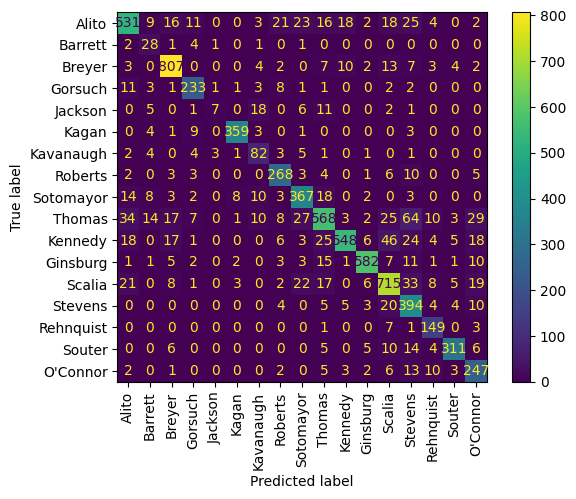

In [ ]:
metrics.plot_confusion(par_test['label'],l, label2id)

In [ ]:
metrics.print_metrics(par_test['author'],[id2label[i] for i in l])


-------------------- Key Metrics --------------------

Accuracy: 0.83
Balanced Accuracy: 0.80

Micro Precision: 0.83
Micro Recall: 0.83
Micro F1-score: 0.83

Macro Precision: 0.78
Macro Recall: 0.80
Macro F1-score: 0.77

Weighted Precision: 0.84
Weighted Recall: 0.83
Weighted F1-score: 0.83

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.83      0.76      0.79       699
     Barrett       0.37      0.74      0.49        38
      Breyer       0.91      0.93      0.92       864
    Ginsburg       0.95      0.90      0.92       645
     Gorsuch       0.84      0.87      0.86       267
     Jackson       0.58      0.14      0.22        51
       Kagan       0.96      0.94      0.95       380
   Kavanaugh       0.61      0.77      0.68       107
     Kennedy       0.93      0.76      0.84       721
    O'Connor       0.70      0.84      0.77       294
   Rehnquist       0.76      0.93      0.83       161
  